In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import sparse,  io, linalg
import pickle
from tqdm import tqdm_notebook as tqdm
import networkx as nx
import snap


def plot_log_log(records):
    fig, ax = plt.subplots()
    # Remove zero values
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    #median_x, median_y = zip(*sorted((xVal, np.median([yVal for a, yVal in zip(records[:,0], records[:,1]) if xVal==a])) for xVal in set(records[:,0])))
    plt.scatter([np.log(r) for r in records[:,0]], [np.log(r) for r in  records[:,1]],s=0.5)
    # Todo add median code
    
def plot(records):
    fig, ax = plt.subplots()
    # Remove zero values
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]
    #median_x, median_y = zip(*sorted((xVal, np.median([yVal for a, yVal in zip(records[:,0], records[:,1]) if xVal==a])) for xVal in set(records[:,0])))
    plt.scatter([(r) for r in records[:,0]], [(r) for r in  records[:,1]],s=0.5)
    # Todo add median code
    
    
def plot_log_log_summary(records,B=20,summary=np.median, discrete=False):
    fig, ax = plt.subplots()
    records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]


    xs = [np.log(record[0]) for record in records]
    ys = [np.log(record[1]) for record in records]
    plt.scatter([(x) for x in xs], [(y) for y in  ys],s=0.5)


    if discrete==False:
        x_max = max(xs) - min(xs)
        # bin into default 20 values
        binned_xs = [min(xs)+(x_max*i)/float(B) for i in range(B+1)]
        median_ys = []
        err = []
        for i in range(B):
            # find median y values for x values in [binned_xs[i], binned_xs[i+1])
            current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
            current_y = summary(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err,color='r')
    else:
        binned_xs = np.unique(xs)
        median_ys = []
        err = []
        for x in binned_xs:
            current_ys = [ys[j] for j in range(len(xs)) if xs[j] == x]
            current_y = summary(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs, median_ys, marker='o', yerr=err,color='r')


    
def plot_summary(records,B=20,summary=np.median, discrete=False):
    fig, ax = plt.subplots()
    #records = records[np.array([idx for idx in range(records.shape[0]) if records[idx, 0]>0 and records[idx,1] > 0]),:]


    xs = [(record[0]) for record in records]
    ys = [(record[1]) for record in records]
    plt.scatter([(x) for x in xs], [(y) for y in  ys],s=0.5)


    if discrete==False:
        x_max = max(xs) - min(xs)
        # bin into default 20 values
        binned_xs = [min(xs)+(x_max*i)/float(B) for i in range(B+1)]
        median_ys = []
        err = []
        for i in range(B):
            # find median y values for x values in [binned_xs[i], binned_xs[i+1])
            current_ys = [ys[j] for j in range(len(xs)) if binned_xs[i] <= xs[j] and xs[j] < binned_xs[i+1]]
            current_y = summary(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs[1:], median_ys, marker='o', yerr=err,color='r')
    else:
        binned_xs = np.unique(xs)
        median_ys = []
        err = []
        for x in binned_xs:
            current_ys = [ys[j] for j in range(len(xs)) if xs[j] == x]
            current_y = summary(current_ys)
            median_ys += [current_y]
            #err += [[median_ys-np.std(current_ys)*0.5,median_ys+np.std(current_ys)*0.5]]
            err += [np.std(current_ys)]
        plt.errorbar(binned_xs, median_ys, marker='o', yerr=err,color='r')





In [2]:
G1=nx.read_adjlist('../oregon/oregon1_010331.txt',nodetype=int)
G2=nx.read_adjlist('../oregon/oregon1_010407.txt',nodetype=int)
G3=nx.read_adjlist('../oregon/oregon1_010421.txt',nodetype=int)
G4=nx.read_adjlist('../oregon/oregon1_010428.txt',nodetype=int)
G5=nx.read_adjlist('../oregon/oregon1_010505.txt',nodetype=int)
G6=nx.read_adjlist('../oregon/oregon1_010512.txt',nodetype=int)
oregon_G = nx.Graph()
for G in [G1, G2, G3, G4, G5, G6]:
    for e in tqdm(G.edges_iter()):
        if oregon_G.has_edge(e[0],e[1]):
            oregon_G[e[0]][e[1]]['weight']+=1
        else:
            oregon_G.add_edge(e[0],e[1],weight=1)

In [3]:
for e in tqdm(oregon_G.edges()):
    oregon_G[e[0]][e[1]]['weight_inv']=1/float(oregon_G[e[0]][e[1]]['weight'])
    oregon_G[e[0]][e[1]]['weight_inv_exp']=np.exp(-float(oregon_G[e[0]][e[1]]['weight'])/3.0)

In [9]:
#mutual neighbors
pwl = []
for e in tqdm(oregon_G.edges()):
    wt = oregon_G[e[0]][e[1]]['weight']/float(oregon_G.degree(e[0],weight='weight')+oregon_G.degree(e[1],weight='weight'))
    nbr1 = set(oregon_G.neighbors(e[0]))
    nbr2 = set(oregon_G.neighbors(e[1]))
    common_nbrs= set.intersection(nbr1,nbr2)
    all_nbrs = set.union(nbr1,nbr2)
    #sim = sum([1/np.log(len(oregon_G.neighbors(v))) for v in common_nbrs])/sum(
    #    [1/np.log(len(oregon_G.neighbors(v))) for v in all_nbrs])
    sim = len(set.intersection(nbr1,nbr2))/float(len(set.union(nbr1,nbr2)))
    #sim = len(set.intersection(nbr1,nbr2))
    pwl += [(wt, sim)]

<IPython.core.display.Javascript object>


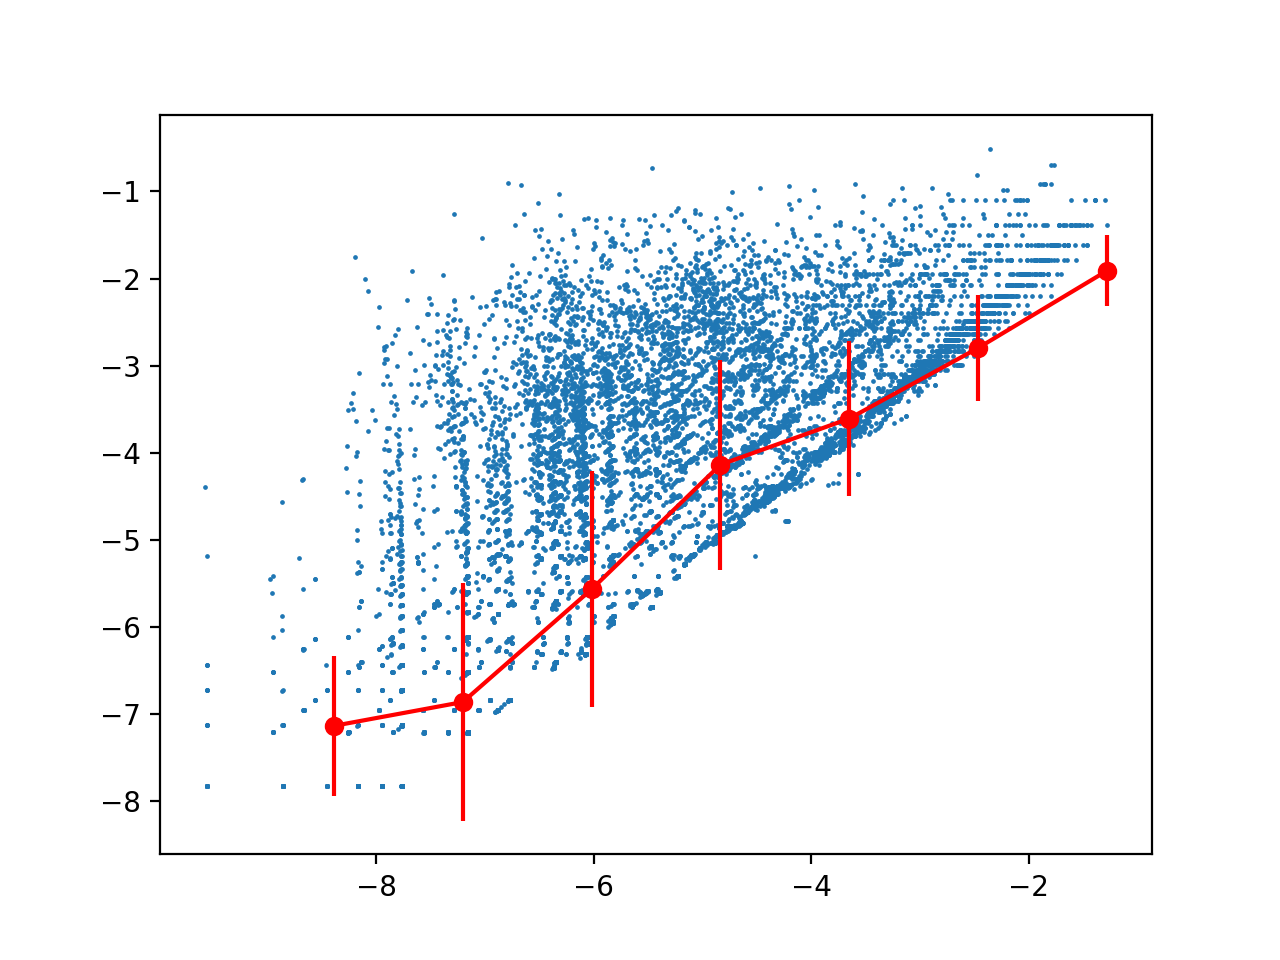

In [11]:
#fig, ax = plt.subplots()
pwl=np.asarray(pwl)
#plt.scatter([r for r in pwl[:,0]], [r for r in  pwl[:,1]],s=0.5)
#plot_median(pwl,B=10)
#plot_log_log(pwl)
plot_log_log_summary(pwl,B=7,summary=np.mean)
#plot_summary(pwl,B=7)


#pwl

In [13]:
#mutual neighbors
pwl = []
for e in tqdm(oregon_G.edges()):
    wt = oregon_G[e[0]][e[1]]['weight']/float(oregon_G.degree(e[0],weight='weight')+oregon_G.degree(e[1],weight='weight'))
    nbr1 = set(oregon_G.neighbors(e[0]))
    nbr2 = set(oregon_G.neighbors(e[1]))
    common_nbrs= set.intersection(nbr1,nbr2)
    all_nbrs = set.union(nbr1,nbr2)
    sim = sum([1/np.log(1+len(oregon_G.neighbors(v))) for v in common_nbrs])/sum(
        [1/np.log(1+len(oregon_G.neighbors(v))) for v in all_nbrs])
    #sim = len(set.intersection(nbr1,nbr2))/float(len(set.union(nbr1,nbr2)))
    #sim = len(set.intersection(nbr1,nbr2))
    pwl += [(wt, sim)]

3584/|/ 14%|| 3584/25458 [00:30<03:03, 119.31it/s]


<IPython.core.display.Javascript object>


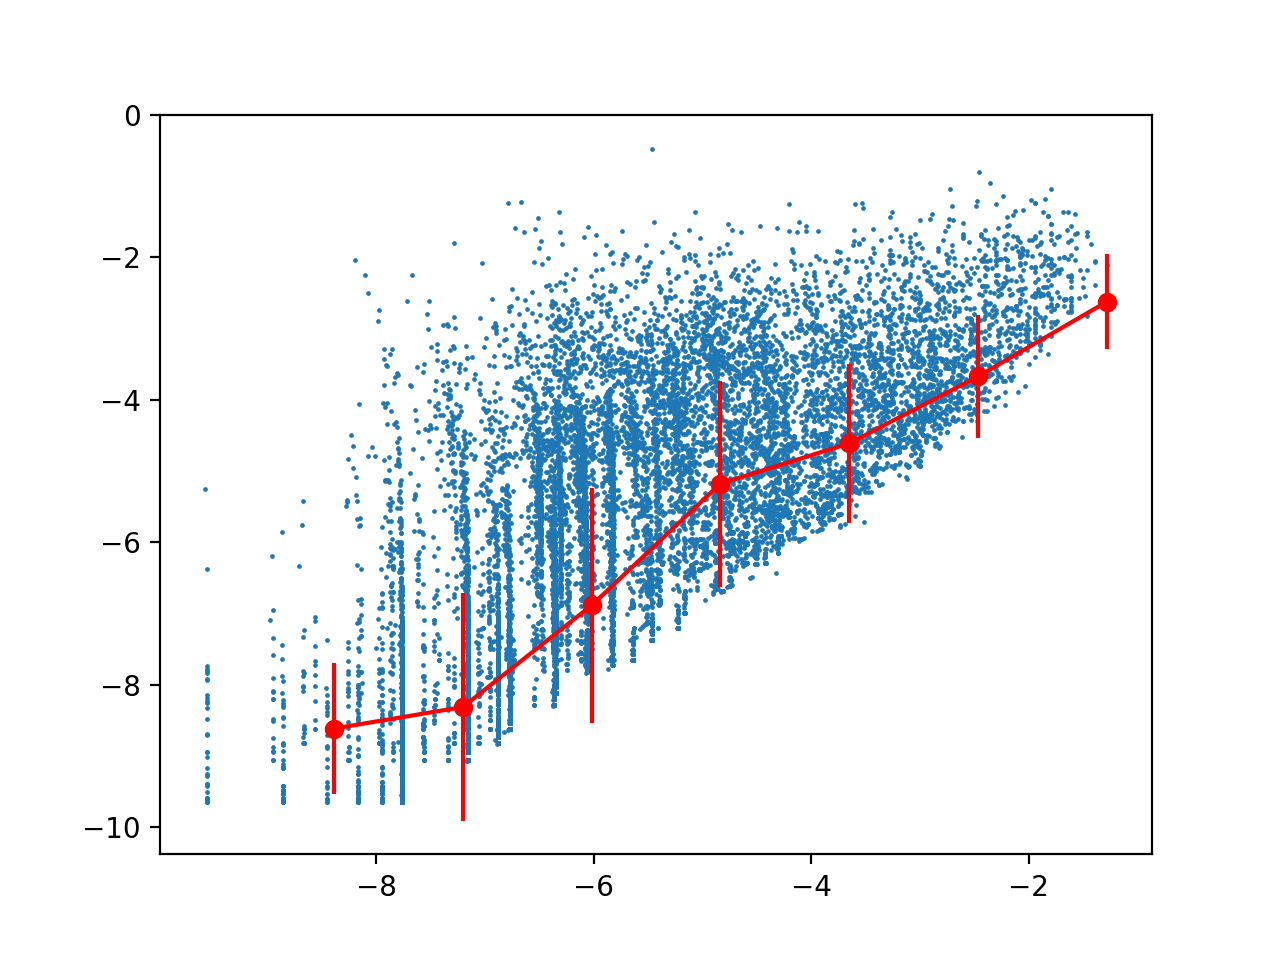

In [14]:
#fig, ax = plt.subplots()
pwl=np.asarray(pwl)
#plt.scatter([r for r in pwl[:,0]], [r for r in  pwl[:,1]],s=0.5)
#plot_median(pwl,B=10)
#plot_log_log(pwl)
plot_log_log_summary(pwl,B=7,summary=np.mean)
#plot_summary(pwl,B=7)


#pwl

In [19]:
pwl = []
for node in tqdm(oregon_G.nodes()):
    for d in [0.16,0.32,0.64,1.0,2.0]:
        pwl += [(d,len(nx.single_source_dijkstra_path_length(oregon_G,node,cutoff=d,weight='weight_inv')))]
pwl=np.asarray(pwl)

KeyboardInterrupt: 

In [20]:
plot_log_log_summary(np.asarray(pwl),discrete=True,summary=np.mean)

<IPython.core.display.Javascript object>